In [2]:
import datetime
import math

from matplotlib import pyplot as plt
from redvox.api1000.wrapped_redvox_packet.wrapped_packet import WrappedRedvoxPacketM
from redvox.common.data_window import DataWindow, DataWindowConfig
import pandas as pd
from scipy.io.wavfile import write
import sys
import re
import shutil
import os
import csv
import datetime
import numpy as np
from research.dataImporting import dataTools
import librosa
from librosa.feature import mfcc
import librosa
import pandas as pd
from librosa.effects import pitch_shift
import os
import pathlib
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from librosa.feature import mfcc,melspectrogram
import scipy.io.wavfile as wav
import tensorflow as tf
import scipy
import scipy.signal as signal
import keras
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.optimizers import adam_v2
from keras.layers import Input, Conv1D,Conv2D,Conv3D,SeparableConv1D,MaxPooling2D, MaxPooling1D, Flatten, Dense, Dropout, \
    BatchNormalization, Activation, LSTM
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import librosa.display

# Range Estimation Dataset Creation (prints to CSV). This is the good one

Data augmentation is a failed effort... does not improve overfitting issues what so ever. In EVP, the ML model that uses data augmentation achieves 0.74 F1 score for EVP and 0.55 Phones.

In [10]:
def convertToGPS(path,name):
    window = dataTools.import_redVoxData(path)
    station = window.first_station()

    locationSensor = station.best_location_sensor()
    if locationSensor:
        lat=locationSensor._data.columns[3]
        lon=locationSensor._data.columns[4]
        alt=locationSensor._data.columns[5]
        phoneGPS.append([name,np.mean(lat),np.mean(lon),150.0]) #gps altitude seems a bit off


def searchDir(rootdir):
    it = 0
    for it in os.scandir(rootdir):
        if it.is_dir():
            # print(it.path)
            searchDir(it)
        else:
            it = os.path.dirname(it)
            break
    if isinstance(it, str):
        splitPath = it.split('\\')
        convertToGPS(it,splitPath[8])

def get_filepaths(data_path):
    data_files=[]
    for path, subdirs, files in os.walk(data_path):
        for name in files:
            data_files.append(os.path.join(path, name))
    return data_files

# def split_audio(waveData, sampleFreq):
#     '''
#     Frames audio data and converts to feature space (MFCC)
#     :param waveData: waveData array of time-domain audio
#     :param sampleFreq: Sample Frequency (8Khz)
#     @return list of features (ds), list of labels corresponding to feature dataset:
#     '''
#     # middle third of data
#     duration = waveData.shape[0]
#     startTime = np.round(duration / 3)
#     endTime = np.round(duration * 2 / 3)
#     waveDataSplit= waveData[int(startTime):int(endTime)]
#     features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
#     #label= [droneDict[labelName]] * features.shape[1]
#     return features

def create_dataset(train_files, totTime):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = {}
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        test_audio, sampleRate = librosa.load(x, sr=8000)
        x = str(x)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)==totTime*8000 :
            #newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            #newFeats, newLabs = split_audio(test_audio, int(sampleRate))
            phone_features = MFCCCalc(test_audio.squeeze(),Fs=8000)
            features[x.split("\\")[7].split(".")[0]]=phone_features.transpose()
        # else:
        #     features.append([x.split("\\")[7].split(".")[0],0.00]) #just trying to fill space

    return features

def create_spect_dataset(train_files, totTime):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = {}
    raw_feats={}
    for x in train_files:
        phone_spects=[]
        phone_raw=[]
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        test_audio, sampleRate = librosa.load(x, sr=8000)
        x = str(x)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)==totTime*8000 :
            #newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            #newFeats, newLabs = split_audio(test_audio, int(sampleRate))
            split=split_audio(test_audio,0.5,.256,8000)
            for frame in split:
                #spect = melspect(frame.squeeze(),Fs=8000)
                frame=np.int16((frame / np.max(np.abs(frame)) * 32767))
                phone_raw.append(frame)
                #spect=spect.flatten() #np.reshape(64,4) to unflatten
                #phone_spects.append(spect)
            #features[x.split("\\")[7].split(".")[0]]=np.array(phone_spects)
            raw_feats[x.split("\\")[7].split(".")[0]]=np.array(phone_raw)
        # else:
        #     features.append([x.split("\\")[7].split(".")[0],0.00]) #just trying to fill space

    return features, raw_feats
def split_audio(audio_data,overlap,size,fs):
    frames=[]
    lead=size*fs
    follow=0
    hop=(overlap*size)*fs
    if overlap == 0:
        hop=size*fs
    while lead<=len(audio_data):
        frames.append(audio_data[int(follow):int(lead)])
        follow= follow+hop
        lead=lead+hop
    return frames
def melspect(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    data= audioData.astype(float)
    spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
    fig, ax = plt.subplots()
    S_dB = librosa.power_to_db(spect, ref=np.max)
    img = librosa.display.specshow(S_dB, x_axis='time',
                             y_axis='mel', sr=8000,
                             fmax=4000, ax=ax)
    fig.colorbar(img, ax=ax, format='%+2.0f dB')
    ax.set(title='Mel-frequency spectrogram')
    return spect

def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=2048,n_fft=2048,n_mfcc=40, sr=Fs)
    return coefs

dictionary_list=[]
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_training_w_Matrice_Phantom.csv")
print()
to_meters=111139
range_df=pd.DataFrame(columns=["Pass","Segment","Name","Lat","Lon","Alt","Range"])
#range_df= pd.DataFrame(index=range(0),columns=(range(263)))
range_raw_df= pd.DataFrame(index=range(0),columns=(range(7)))
#range_df=pd.DataFrame()
#test123=readDirectoryCSV(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_flight_directory.csv")
def distanceCalc(phoneLat,phoneLon,phoneAlt, droneLat,droneLon,droneAlt):
    lat_delta= (phoneLat-droneLat)*to_meters
    lon_delta=(phoneLon-droneLon)*to_meters
    return np.sqrt((lat_delta**2+lon_delta**2+(phoneAlt-droneAlt)**2))


def maxValueRanks(maxValArray):
    maxValueRankArr=[]
    for x in maxValArray:
        seq = sorted(x)
        index = [seq.index(v) for v in x]
        maxValueRankArr.append(index)
    return maxValueRankArr

for x in passes_df.iterrows():
    #indiv_df=pd.DataFrame(columns=["Pass","Segment","Name","Lat","Lon","Alt","Range",'MFCC_0'])
    #indiv_df= pd.DataFrame(index=range(0),columns=(range(263)))
    indiv_raw_df= pd.DataFrame(index=range(0),columns=(range(47)))
    phoneGPS=[]
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()

    searchDir(("C:\\Users\\rclendening\\researchData\\Unused_Datasets\\EscapeCell_Data\\"+scenario+"\\"+full_name))
    GPS_df=pd.DataFrame(phoneGPS, columns=['Name','Lat','Lon','Alt'])

    start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
    stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
    if drone_gps_file[0]== 'F':
        FLY=True
    else:
        FLY=False
    GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))
    print("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv")
    if FLY:
        lon=GPS_flight_log.iloc[:,4]
        offsets=GPS_flight_log.iloc[:,1]
        lat=GPS_flight_log.iloc[:,5]
        time=GPS_flight_log.iloc[:,7]
        date=GPS_flight_log.iloc[:,8]
        height=GPS_flight_log.iloc[:,9]
    else:
        lon=GPS_flight_log.iloc[:,3]/10**7
        lat=GPS_flight_log.iloc[:,2]/10**7
        time_UTC=GPS_flight_log.iloc[:,1]/10**6
        #height=GPS_flight_log.iloc[:,5]/10**3
        height=GPS_flight_log.iloc[:,4]/10**3
    #for phones in GPS_df: #FLY files Long=col(5) lat=col(6) date=col(7) time=col(8) height (MSL)=col(10)
                        #Non-FLY files lat=col(3) lon=col(4) timestamp(UTC)=col(1) height (MSL)= col(5) in millimeters
    usable_phones=[]
    tot_time= stop_time-start_time

    filepaths= get_filepaths("C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\"+scenario+"\\"+full_name)
    phone_features= create_dataset(filepaths,tot_time)
    #phone_features, phone_raw= create_dataset(filepaths,tot_time)
    first =True
    for ph in phoneGPS:
        if 43.00 < ph[1] < 44.00 and -75.00 > ph[2] > -76.00 and ph[0] in phone_features:
            usable_phones.append(ph)
    tot_segs = len(phone_features[list(phone_features.keys())[0]])
    #tot_segs=tot_time/.128
    # for t in range(0,len(GPS_flight_log),10):
    t=0
    done=False
    MFCC_index=0
    while not done:
        if FLY:
            if np.isnan(time[t]):
                cur_time=0
            else:
                if first:
                    offset=offsets[t]
                    first=False
                    offset_time=datetime.datetime(2021, 8, int(start[6:8]), int(str(time[t])[0:2])-4,int(str(time[t])[2:4]),int(str(time[t])[4:6])).timestamp()
                cur_time=offset_time+abs(offsets[t]-offset)
        else:
            cur_time=time_UTC[t]

        time_delta=cur_time-start_time
        prev_index=MFCC_index
        MFCC_index = math.floor(tot_segs*time_delta/tot_time)
        if  start_time <= cur_time< stop_time and MFCC_index!= prev_index:
            #MFCC_df=pd.DataFrame()
            for phone in usable_phones:
                val = distanceCalc(phone[1],phone[2],phone[3], lat[t],lon[t],height[t])
                # range_df.loc[len(range_df.index)]=[str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),pd.Series(phone_features[phone[0]][MFCC_index])]

                #data=[full_name,str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),start_time,cur_time]

                #data=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                #data.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                data_raw=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                data_raw.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                #indiv_df.loc[len(indiv_df.index)]=data
                indiv_raw_df.loc[len(indiv_raw_df.index)]=data_raw
        t+=4
        if cur_time>stop_time:
            done=True

    #range_df= pd.concat([range_df, indiv_df])
    range_raw_df=pd.concat([range_raw_df,indiv_raw_df])
#range_df.to_csv('0.5s_spec_range_A1_A2_A3_no_overlap.csv')
range_raw_df.to_csv('LT80m_detection_training_w_matrice_phantom.csv')

C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\2244936242.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv


# Up-samp Down-samp

In [14]:
def convertToGPS(path,name):
    window = dataTools.import_redVoxData(path)
    station = window.first_station()

    locationSensor = station.best_location_sensor()
    if locationSensor:
        lat=locationSensor._data.columns[3]
        lon=locationSensor._data.columns[4]
        alt=locationSensor._data.columns[5]
        phoneGPS.append([name,np.mean(lat),np.mean(lon),150.0]) #gps altitude seems a bit off


def searchDir(rootdir):
    it = 0
    for it in os.scandir(rootdir):
        if it.is_dir():
            # print(it.path)
            searchDir(it)
        else:
            it = os.path.dirname(it)
            break
    if isinstance(it, str):
        splitPath = it.split('\\')
        convertToGPS(it,splitPath[8])

def get_filepaths(data_path):
    data_files=[]
    for path, subdirs, files in os.walk(data_path):
        for name in files:
            data_files.append(os.path.join(path, name))
    return data_files

# def split_audio(waveData, sampleFreq):
#     '''
#     Frames audio data and converts to feature space (MFCC)
#     :param waveData: waveData array of time-domain audio
#     :param sampleFreq: Sample Frequency (8Khz)
#     @return list of features (ds), list of labels corresponding to feature dataset:
#     '''
#     # middle third of data
#     duration = waveData.shape[0]
#     startTime = np.round(duration / 3)
#     endTime = np.round(duration * 2 / 3)
#     waveDataSplit= waveData[int(startTime):int(endTime)]
#     features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
#     #label= [droneDict[labelName]] * features.shape[1]
#     return features

def create_dataset(train_files, totTime):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = {}
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        test_audio, sampleRate = librosa.load(x, sr=8000)
        x = str(x)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)==totTime*8000 :
            #newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            #newFeats, newLabs = split_audio(test_audio, int(sampleRate))
            phone_features = MFCCCalc(test_audio.squeeze(),Fs=8000)
            features[x.split("\\")[7].split(".")[0]]=phone_features.transpose()
        # else:
        #     features.append([x.split("\\")[7].split(".")[0],0.00]) #just trying to fill space

    return features

def create_aug_dataset(train_files, totTime, fs):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = {}
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        test_audio, sampleRate = librosa.load(x, sr=fs)
        x = str(x)
        if min(np.asarray(test_audio)) != 0 and (len(test_audio)*8000/fs)>(totTime-0.5)*8000 and (len(test_audio)*8000/fs)<(totTime+0.5)*8000:
            #newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            #newFeats, newLabs = split_audio(test_audio, int(sampleRate))
            phone_features = MFCCCalc(test_audio.squeeze(),Fs=8000)
            features[x.split("\\")[7].split(".")[0]]=phone_features.transpose()
        # else:
        #     features.append([x.split("\\")[7].split(".")[0],0.00]) #just trying to fill space

    return features
def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=2048,n_fft=2048,n_mfcc=40, sr=Fs)
    return coefs
aug_vals=[7000,7200,7400,7600,7800,8000,8200,8400,8600,8800,9000]
dictionary_list=[]
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_training_w_Matrice_Phantom.csv")
print()
to_meters=111139
range_df=pd.DataFrame(columns=["Pass","Segment","Name","Lat","Lon","Alt","Range"])
#range_df= pd.DataFrame(index=range(0),columns=(range(263)))
range_raw_df= pd.DataFrame(index=range(0),columns=(range(7)))
#range_df=pd.DataFrame()
#test123=readDirectoryCSV(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_flight_directory.csv")
def distanceCalc(phoneLat,phoneLon,phoneAlt, droneLat,droneLon,droneAlt):
    lat_delta= (phoneLat-droneLat)*to_meters
    lon_delta=(phoneLon-droneLon)*to_meters
    return np.sqrt((lat_delta**2+lon_delta**2+(phoneAlt-droneAlt)**2))


def maxValueRanks(maxValArray):
    maxValueRankArr=[]
    for x in maxValArray:
        seq = sorted(x)
        index = [seq.index(v) for v in x]
        maxValueRankArr.append(index)
    return maxValueRankArr

for x in passes_df.iterrows():
    #indiv_df=pd.DataFrame(columns=["Pass","Segment","Name","Lat","Lon","Alt","Range",'MFCC_0'])
    #indiv_df= pd.DataFrame(index=range(0),columns=(range(263)))
    indiv_raw_df= pd.DataFrame(index=range(0),columns=(range(47)))
    phoneGPS=[]
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    if scenario =="A3":
        for x in aug_vals:
            indiv_raw_df= pd.DataFrame(index=range(0),columns=(range(47)))
            searchDir(("C:\\Users\\rclendening\\researchData\\Unused_Datasets\\EscapeCell_Data\\"+scenario+"\\"+full_name))
            GPS_df=pd.DataFrame(phoneGPS, columns=['Name','Lat','Lon','Alt'])
            start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
            stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
            if drone_gps_file[0]== 'F':
                FLY=True
            else:
                FLY=False
            GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))
            print("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv")
            if FLY:
                lon=GPS_flight_log.iloc[:,4]
                offsets=GPS_flight_log.iloc[:,1]
                lat=GPS_flight_log.iloc[:,5]
                time=GPS_flight_log.iloc[:,7]
                date=GPS_flight_log.iloc[:,8]
                height=GPS_flight_log.iloc[:,9]
            else:
                lon=GPS_flight_log.iloc[:,3]/10**7
                lat=GPS_flight_log.iloc[:,2]/10**7
                time_UTC=GPS_flight_log.iloc[:,1]/10**6
                #height=GPS_flight_log.iloc[:,5]/10**3
                height=GPS_flight_log.iloc[:,4]/10**3
            #for phones in GPS_df: #FLY files Long=col(5) lat=col(6) date=col(7) time=col(8) height (MSL)=col(10)
                                #Non-FLY files lat=col(3) lon=col(4) timestamp(UTC)=col(1) height (MSL)= col(5) in millimeters
            usable_phones=[]
            tot_time= stop_time-start_time

            filepaths= get_filepaths("C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\"+scenario+"\\"+full_name)
            phone_features = create_aug_dataset(filepaths,tot_time,fs=x)
            #phone_features, phone_raw= create_dataset(filepaths,tot_time)
            first =True
            for ph in phoneGPS:
                if 43.00 < ph[1] < 44.00 and -75.00 > ph[2] > -76.00 and ph[0] in phone_features:
                    usable_phones.append(ph)
            tot_segs = len(phone_features[list(phone_features.keys())[0]])
            #tot_segs=tot_time/.128
            # for t in range(0,len(GPS_flight_log),10):
            t=0
            done=False
            MFCC_index=0
            while not done:
                if FLY:
                    if np.isnan(time[t]):
                        cur_time=0
                    else:
                        if first:
                            offset=offsets[t]
                            first=False
                            offset_time=datetime.datetime(2021, 8, int(start[6:8]), int(str(time[t])[0:2])-4,int(str(time[t])[2:4]),int(str(time[t])[4:6])).timestamp()
                        cur_time=offset_time+abs(offsets[t]-offset)
                else:
                    cur_time=time_UTC[t]

                time_delta=cur_time-start_time
                prev_index=MFCC_index
                MFCC_index = math.floor(tot_segs*time_delta/tot_time)
                if  start_time <= cur_time< stop_time and MFCC_index!= prev_index:
                    #MFCC_df=pd.DataFrame()
                    for phone in usable_phones:
                        val = distanceCalc(phone[1],phone[2],phone[3], lat[t],lon[t],height[t])
                        # range_df.loc[len(range_df.index)]=[str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),pd.Series(phone_features[phone[0]][MFCC_index])]

                        #data=[full_name,str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),start_time,cur_time]

                        #data=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                        #data.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                        data_raw=[full_name+"_"+str(x).strip(),str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                        data_raw.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                        #indiv_df.loc[len(indiv_df.index)]=data
                        indiv_raw_df.loc[len(indiv_raw_df.index)]=data_raw
                t+=4
                if cur_time>stop_time:
                    done=True

            #range_df= pd.concat([range_df, indiv_df])
            range_raw_df=pd.concat([range_raw_df,indiv_raw_df])
    else:
        searchDir(("C:\\Users\\rclendening\\researchData\\Unused_Datasets\\EscapeCell_Data\\"+scenario+"\\"+full_name))
        GPS_df=pd.DataFrame(phoneGPS, columns=['Name','Lat','Lon','Alt'])
        start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
        stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
        if drone_gps_file[0]== 'F':
            FLY=True
        else:
            FLY=False
        GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))
        print("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv")
        if FLY:
            lon=GPS_flight_log.iloc[:,4]
            offsets=GPS_flight_log.iloc[:,1]
            lat=GPS_flight_log.iloc[:,5]
            time=GPS_flight_log.iloc[:,7]
            date=GPS_flight_log.iloc[:,8]
            height=GPS_flight_log.iloc[:,9]
        else:
            lon=GPS_flight_log.iloc[:,3]/10**7
            lat=GPS_flight_log.iloc[:,2]/10**7
            time_UTC=GPS_flight_log.iloc[:,1]/10**6
            #height=GPS_flight_log.iloc[:,5]/10**3
            height=GPS_flight_log.iloc[:,4]/10**3
        #for phones in GPS_df: #FLY files Long=col(5) lat=col(6) date=col(7) time=col(8) height (MSL)=col(10)
                            #Non-FLY files lat=col(3) lon=col(4) timestamp(UTC)=col(1) height (MSL)= col(5) in millimeters
        usable_phones=[]
        tot_time= stop_time-start_time

        filepaths= get_filepaths("C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\"+scenario+"\\"+full_name)
        phone_features= create_dataset(filepaths,tot_time)
        #phone_features, phone_raw= create_dataset(filepaths,tot_time)
        first =True
        for ph in phoneGPS:
            if 43.00 < ph[1] < 44.00 and -75.00 > ph[2] > -76.00 and ph[0] in phone_features:
                usable_phones.append(ph)
        tot_segs = len(phone_features[list(phone_features.keys())[0]])
        #tot_segs=tot_time/.128
        # for t in range(0,len(GPS_flight_log),10):
        t=0
        done=False
        MFCC_index=0
        while not done:
            if FLY:
                if np.isnan(time[t]):
                    cur_time=0
                else:
                    if first:
                        offset=offsets[t]
                        first=False
                        offset_time=datetime.datetime(2021, 8, int(start[6:8]), int(str(time[t])[0:2])-4,int(str(time[t])[2:4]),int(str(time[t])[4:6])).timestamp()
                    cur_time=offset_time+abs(offsets[t]-offset)
            else:
                cur_time=time_UTC[t]

            time_delta=cur_time-start_time
            prev_index=MFCC_index
            MFCC_index = math.floor(tot_segs*time_delta/tot_time)
            if  start_time <= cur_time< stop_time and MFCC_index!= prev_index:
                #MFCC_df=pd.DataFrame()
                for phone in usable_phones:
                    val = distanceCalc(phone[1],phone[2],phone[3], lat[t],lon[t],height[t])
                    # range_df.loc[len(range_df.index)]=[str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),pd.Series(phone_features[phone[0]][MFCC_index])]

                    #data=[full_name,str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),start_time,cur_time]

                    #data=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                    #data.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                    data_raw=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                    data_raw.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                    #indiv_df.loc[len(indiv_df.index)]=data
                    indiv_raw_df.loc[len(indiv_raw_df.index)]=data_raw
            t+=4
            if cur_time>stop_time:
                done=True
        #range_df= pd.concat([range_df, indiv_df])
        range_raw_df=pd.concat([range_raw_df,indiv_raw_df])
#range_df.to_csv('0.5s_spec_range_A1_A2_A3_no_overlap.csv')
range_raw_df.to_csv('LT80m_detection_training_w_matrice_phantom_augment_A1_A2_A3.csv')

C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:229: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_8772\3464163070.py:151: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv


# Just ranges

In [11]:
def convertToGPS(path,name):
    window = dataTools.import_redVoxData(path)
    station = window.first_station()

    locationSensor = station.best_location_sensor()
    if locationSensor:
        lat=locationSensor._data.columns[3]
        lon=locationSensor._data.columns[4]
        alt=locationSensor._data.columns[5]
        phoneGPS.append([name,np.mean(lat),np.mean(lon),150.0]) #gps altitude seems a bit off


def searchDir(rootdir):
    it = 0
    for it in os.scandir(rootdir):
        if it.is_dir():
            # print(it.path)
            searchDir(it)
        else:
            it = os.path.dirname(it)
            break
    if isinstance(it, str):
        splitPath = it.split('\\')
        convertToGPS(it,splitPath[8])

def get_filepaths(data_path):
    data_files=[]
    for path, subdirs, files in os.walk(data_path):
        for name in files:
            data_files.append(os.path.join(path, name))
    return data_files

# def split_audio(waveData, sampleFreq):
#     '''
#     Frames audio data and converts to feature space (MFCC)
#     :param waveData: waveData array of time-domain audio
#     :param sampleFreq: Sample Frequency (8Khz)
#     @return list of features (ds), list of labels corresponding to feature dataset:
#     '''
#     # middle third of data
#     duration = waveData.shape[0]
#     startTime = np.round(duration / 3)
#     endTime = np.round(duration * 2 / 3)
#     waveDataSplit= waveData[int(startTime):int(endTime)]
#     features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
#     #label= [droneDict[labelName]] * features.shape[1]
#     return features

def create_dataset(train_files, totTime):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = {}
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        test_audio, sampleRate = librosa.load(x, sr=8000)
        x = str(x)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)==totTime*8000 :
            #newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            #newFeats, newLabs = split_audio(test_audio, int(sampleRate))
            phone_features = MFCCCalc(test_audio.squeeze(),Fs=8000)
            features[x.split("\\")[7].split(".")[0]]=phone_features.transpose()
        # else:
        #     features.append([x.split("\\")[7].split(".")[0],0.00]) #just trying to fill space

    return features

def create_aug_dataset(train_files, totTime, fs):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = {}
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        test_audio, sampleRate = librosa.load(x, sr=fs)
        x = str(x)
        if min(np.asarray(test_audio)) != 0 and (len(test_audio)*8000/fs)==totTime*8000 :
            #newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            #newFeats, newLabs = split_audio(test_audio, int(sampleRate))
            phone_features = MFCCCalc(test_audio.squeeze(),Fs=8000)
            features[x.split("\\")[7].split(".")[0]]=phone_features.transpose()
        # else:
        #     features.append([x.split("\\")[7].split(".")[0],0.00]) #just trying to fill space

    return features
def MFCCCalc(audioData, Fs):
    '''
    Converts decoded wav file to MFCC feature space
    @param audioData: Numpy array of decoded audio wav file
    @return MFCC coefficients
    '''
    #audioData=audioData.numpy()
    data= audioData.astype(float)
    #coefs = mfcc(data, sr=sampleRate, hop_length=2048)
    coefs = mfcc(y=data, hop_length=2048,n_fft=2048,n_mfcc=40, sr=Fs)
    return coefs

dictionary_list=[]
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A3_flight_directory.csv")
print()
to_meters=111139
range_df=pd.DataFrame(columns=["Pass","Segment","Name","Lat","Lon","Alt","Range"])
#range_df= pd.DataFrame(index=range(0),columns=(range(263)))
range_raw_df= pd.DataFrame(index=range(0),columns=(range(7)))
#range_df=pd.DataFrame()
#test123=readDirectoryCSV(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_flight_directory.csv")
def distanceCalc(phoneLat,phoneLon,phoneAlt, droneLat,droneLon,droneAlt):
    lat_delta= (phoneLat-droneLat)*to_meters
    lon_delta=(phoneLon-droneLon)*to_meters
    return np.sqrt((lat_delta**2+lon_delta**2+(phoneAlt-droneAlt)**2))


def maxValueRanks(maxValArray):
    maxValueRankArr=[]
    for x in maxValArray:
        seq = sorted(x)
        index = [seq.index(v) for v in x]
        maxValueRankArr.append(index)
    return maxValueRankArr

for x in passes_df.iterrows():
    #indiv_df=pd.DataFrame(columns=["Pass","Segment","Name","Lat","Lon","Alt","Range",'MFCC_0'])
    #indiv_df= pd.DataFrame(index=range(0),columns=(range(263)))
    indiv_raw_df= pd.DataFrame(index=range(0),columns=(range(7)))
    phoneGPS=[]
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()

    searchDir(("C:\\Users\\rclendening\\researchData\\Unused_Datasets\\EscapeCell_Data\\"+scenario+"\\"+full_name))
    GPS_df=pd.DataFrame(phoneGPS, columns=['Name','Lat','Lon','Alt'])

    start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
    stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
    if drone_gps_file[0]== 'F':
        FLY=True
    else:
        FLY=False
    GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))
    print("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv")
    if FLY:
        lon=GPS_flight_log.iloc[:,4]
        offsets=GPS_flight_log.iloc[:,1]
        lat=GPS_flight_log.iloc[:,5]
        time=GPS_flight_log.iloc[:,7]
        date=GPS_flight_log.iloc[:,8]
        height=GPS_flight_log.iloc[:,9]
    else:
        lon=GPS_flight_log.iloc[:,3]/10**7
        lat=GPS_flight_log.iloc[:,2]/10**7
        time_UTC=GPS_flight_log.iloc[:,1]/10**6
        #height=GPS_flight_log.iloc[:,5]/10**3
        height=GPS_flight_log.iloc[:,4]/10**3
    #for phones in GPS_df: #FLY files Long=col(5) lat=col(6) date=col(7) time=col(8) height (MSL)=col(10)
                        #Non-FLY files lat=col(3) lon=col(4) timestamp(UTC)=col(1) height (MSL)= col(5) in millimeters
    usable_phones=[]
    tot_time= stop_time-start_time

    filepaths= get_filepaths("C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\"+scenario+"\\"+full_name)
    phone_features= create_dataset(filepaths,tot_time)
    #phone_features, phone_raw= create_dataset(filepaths,tot_time)
    first =True
    for ph in phoneGPS:
        if 43.00 < ph[1] < 44.00 and -75.00 > ph[2] > -76.00 and ph[0] in phone_features:
            usable_phones.append(ph)
    tot_segs = len(phone_features[list(phone_features.keys())[0]])
    # for t in range(0,len(GPS_flight_log),10):
    t=0
    done=False
    MFCC_index=0
    while not done:
        if FLY:
            if np.isnan(time[t]):
                cur_time=0
            else:
                if first:
                    offset=offsets[t]
                    first=False
                    offset_time=datetime.datetime(2021, 8, int(start[6:8]), int(str(time[t])[0:2])-4,int(str(time[t])[2:4]),int(str(time[t])[4:6])).timestamp()
                cur_time=offset_time+abs(offsets[t]-offset)
        else:
            cur_time=time_UTC[t]

        time_delta=cur_time-start_time
        prev_index=MFCC_index
        MFCC_index = math.floor(tot_segs*time_delta/tot_time)
        if  start_time <= cur_time< stop_time and MFCC_index!= prev_index:
            #MFCC_df=pd.DataFrame()
            for phone in usable_phones:
                val = distanceCalc(phone[1],phone[2],phone[3], lat[t],lon[t],height[t])
                # range_df.loc[len(range_df.index)]=[str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),pd.Series(phone_features[phone[0]][MFCC_index])]

                #data=[full_name,str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),start_time,cur_time]

                #data=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                #data.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                data_raw=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                #data_raw.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                #indiv_df.loc[len(indiv_df.index)]=data
                indiv_raw_df.loc[len(indiv_raw_df.index)]=data_raw
        t+=4
        if cur_time>stop_time:
            done=True

    #range_df= pd.concat([range_df, indiv_df])
    range_raw_df=pd.concat([range_raw_df,indiv_raw_df])
#range_df.to_csv('0.5s_spec_range_A1_A2_A3_no_overlap.csv')
range_raw_df.to_csv('A3_Range_truth_dot256ms.csv')

C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY037.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY037.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY037.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_12432\473260165.py:189: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY037.csv


# 2D Range Estimation Dataset (Stores to x_data and y_data)

In [4]:
#training_df=pd.read_csv("./spect_range_csv.csv")
training_df=pd.read_csv(r"C:\Users\rclendening\researchData\range_training.csv")


In [17]:
# train_feats=np.array(training_df.iloc[:, -256:])
# train_targs=np.array(training_df.iloc[:,6])
# train_feats=np.reshape(train_feats,(len(train_feats),64,4))

train_feats=np.array(training_df.iloc[:, -40:])
train_targs=np.array(training_df.iloc[:,7])
train_feats=np.reshape(train_feats,(len(train_feats),40,1))

In [18]:
print(train_targs)

[ 89.33132407 175.61062749  78.9229703  ... 396.98564872 503.78703192
 512.70897096]


In [32]:
phone_slots=["Phone_1-1","Phone_1-3","Phone_11","Phone_12","Phone_15","Phone_2-3","Phone_2-4", "Phone_2-5","Phone_27","Phone_28","Phone_29" "Phone_3-1","Phone_3-2","Phone_3-4","Phone_3-5","Phone_30","Phone_5-2","Phone_5-3","Phone_5-4","Phone_6-2","Phone_6-3","Phone_6-4","Phone_6-5","Phone_7-1","Phone_7-2","Phone_8","Phone_9"]
notable_col_names=['Pass','Segment','Phone','Lat','Lon','Alt','Range']
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_flight_directory.csv")
x_data=[]
y_data=[]
def rangeFraction(ranges): #Function normalizes ranges
    closest=np.min(ranges)
    return closest*1/ranges
def rangeClosest(ranges): #Function normalizes ranges
    ranges_copy=ranges
    truth=np.zeros(len(ranges))
    #for x in range(0, 2):
    closest=np.argmin(ranges_copy)
    ranges_copy[closest]=10000
    truth[closest]=1
    return truth
for x in passes_df.iterrows():
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()
    #pass_df=training_df.loc[training_df[str(notable_col_names.index('Pass'))] == full_name]
    pass_df=training_df.loc[training_df["Pass"] == full_name]
    #max_segment=pass_df[str(notable_col_names.index('Segment'))].max()
    max_segment=pass_df["Segment"].max()
    for i in range(0,max_segment):
        #frame_df=pass_df.loc[pass_df[str(notable_col_names.index('Segment'))]==i]
        frame_df=pass_df.loc[pass_df["Segment"]==i]
        twd_frame=[]
        range_frame=[]
        for phone in phone_slots:
            #phone_seg=frame_df.loc[frame_df[str(notable_col_names.index('Phone'))]==phone]
            phone_seg=frame_df.loc[frame_df["Name"]==phone]
            data=np.array(phone_seg.iloc[:,-40:])
            #dist=phone_seg[str(notable_col_names.index('Range'))]
            dist=phone_seg["Range"]
            if not np.any(data):
                #data=np.zeros((64,4))
                data=np.zeros((40,1))
                dist=100000
            else:
                data=data[0]
                #data=np.reshape(data,(64,4))
                data=np.reshape(data,(40,1))
                dist=np.array(dist)[0]
            twd_frame.append(data)
            range_frame.append(dist)
        y_vals= rangeClosest(range_frame)
        x_data.append([np.array(twd_frame)])
        y_data.append([y_vals])

In [33]:
x_array=np.array(x_data)
# x_array=np.reshape(x_array,(len(x_array),26,64,4))
x_array=np.reshape(x_array,(len(x_array),26,40,1))
##mean = x_array.mean(axis=0)
##x_array -= mean
##std = x_array.std(axis=0)
##x_array /= std
y_array=np.array(y_data).reshape(len(y_data),26)
# print(len(x_array))

In [34]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train = scaler.fit_transform(x_array.reshape(-1, x_array.shape[-1])).reshape(x_array.shape)
X_test = scaler.transform(x_array.reshape(-1, x_array.shape[-1])).reshape(x_array.shape)
x_array=x_array.reshape((len(x_array),26,40,1))

# Model that tries to predict which device is closest.

In [42]:
model =tf.keras.Sequential()
#model.add(BatchNormalization(input_shape=(1,26,40)))
model.add(Conv2D(filters=2,kernel_size=(3,3),strides=(1,1), use_bias=False,input_shape=(26,40,1), name='conv_1',padding='Valid'))
#model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=2,kernel_size=(3,3),strides=(1,1), use_bias=False, name='conv_2',padding='Same'))
#model.add(Dropout(0.5))
model.add(Activation('relu'))
model.add(BatchNormalization())
#model.add(MaxPooling2D((2,2), strides=2))
# model.add(Conv3D(filters=2,kernel_size=(2,2,2), use_bias=False,
#                           name='conv_2',padding='Same'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
#model.add(MaxPooling1D(64, strides=2))
# hidden = MaxPooling1D(3, strides=2)(hidden)
# model.add(Conv2D(filters=2,kernel_size=3, strides=2, use_bias=False, name='conv_3'))
# model.add(BatchNormalization())
# model.add(Activation('sigmoid'))
model.add(Dropout(0.3))
model.add(Flatten())
#model.add(MaxPooling1D(3, strides=2))
#model.add(LSTM(32))
#model.add(Dense(256, activation='relu', name='dense_1'))
#model.add(Dropout(0.5))
model.add(Dense(52, activation='relu', name='dense_2'))
#model.add(LSTM(16))
#model.add(Dense(6, activation='sigmoid', name='dense_3'))
model.add(Dropout(0.3))
model.add(Dense(26, activation='softmax', name='dense_4'))


optimizer= tf.keras.optimizers.Adam(learning_rate=0.2)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),optimizer='rmsprop',metrics=['Accuracy'])


reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 verbose=1, patience=10, mode='auto')
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                          patience=40, mode='auto', restore_best_weights=True)

history = model.fit(X_train, y_array,
                      epochs=200,
                      batch_size=64,
                      shuffle=True,
                      validation_split=0.2,
                      callbacks=[reduceLR, early])
model.summary()
#3d spectogram complete failure... need way more data

Epoch 1/200
131/131 [==============================] - 6s 33ms/step - loss: 0.5992 - Accuracy: 0.8183 - val_loss: 2.6191 - val_Accuracy: 0.3588 - lr: 0.0010
Epoch 2/200
131/131 [==============================] - 4s 30ms/step - loss: 0.1896 - Accuracy: 0.9384 - val_loss: 3.8986 - val_Accuracy: 0.3416 - lr: 0.0010
Epoch 3/200
131/131 [==============================] - 4s 30ms/step - loss: 0.1172 - Accuracy: 0.9606 - val_loss: 5.2643 - val_Accuracy: 0.3249 - lr: 0.0010
Epoch 4/200
131/131 [==============================] - 5s 36ms/step - loss: 0.0880 - Accuracy: 0.9712 - val_loss: 6.6915 - val_Accuracy: 0.3239 - lr: 0.0010
Epoch 5/200
131/131 [==============================] - 8s 61ms/step - loss: 0.0677 - Accuracy: 0.9781 - val_loss: 8.4042 - val_Accuracy: 0.3134 - lr: 0.0010
Epoch 6/200
131/131 [==============================] - 7s 51ms/step - loss: 0.0626 - Accuracy: 0.9792 - val_loss: 7.8471 - val_Accuracy: 0.3158 - lr: 0.0010
Epoch 7/200
131/131 [==============================] - 5s 

KeyboardInterrupt: 

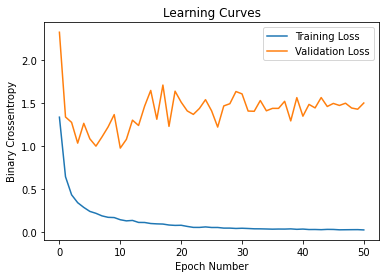

In [202]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning Curves')
plt.legend(['Training Loss', 'Validation Loss'])
plt.ylabel('Binary Crossentropy')
plt.xlabel('Epoch Number')
plt.show()

# Azimuth, Range, Angle for Cluster

In [3]:
import pyproj
cluster=["Phone_28","Phone_3-5","Phone_3-4","Phone_3-2","Phone_2-5","Phone_5-3","Phone_30","Phone_6-5","Phone_11","Phone_5-2","Phone_9","Phone_7-2"]
def convertToGPS(path,name):
    window = dataTools.import_redVoxData(path)
    station = window.first_station()

    locationSensor = station.best_location_sensor()
    if locationSensor:
        lat=locationSensor._data.columns[3]
        lon=locationSensor._data.columns[4]
        alt=locationSensor._data.columns[5]
        phoneGPS.append([name,np.mean(lat),np.mean(lon),150.0]) #gps altitude seems a bit off


def searchDir(rootdir):
    it = 0
    for it in os.scandir(rootdir):
        if it.is_dir():
            # print(it.path)
            searchDir(it)
        else:
            it = os.path.dirname(it)
            break
    if isinstance(it, str):
        splitPath = it.split('\\')
        convertToGPS(it,splitPath[8])

def get_filepaths(data_path):
    data_files=[]
    for path, subdirs, files in os.walk(data_path):
        for name in files:
            data_files.append(os.path.join(path, name))
    return data_files

# def split_audio(waveData, sampleFreq):
#     '''
#     Frames audio data and converts to feature space (MFCC)
#     :param waveData: waveData array of time-domain audio
#     :param sampleFreq: Sample Frequency (8Khz)
#     @return list of features (ds), list of labels corresponding to feature dataset:
#     '''
#     # middle third of data
#     duration = waveData.shape[0]
#     startTime = np.round(duration / 3)
#     endTime = np.round(duration * 2 / 3)
#     waveDataSplit= waveData[int(startTime):int(endTime)]
#     features=MFCCCalc(waveDataSplit.squeeze(), sampleFreq)
#     #label= [droneDict[labelName]] * features.shape[1]
#     return features

def create_dataset(train_files, totTime):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = {}
    for x in train_files:
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        test_audio, sampleRate = librosa.load(x, sr=8000)
        x = str(x)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)==totTime*8000 :
            #newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            #newFeats, newLabs = split_audio(test_audio, int(sampleRate))
            phone_features = MFCCCalc(test_audio.squeeze(),Fs=8000)
            features[x.split("\\")[7].split(".")[0]]=phone_features.transpose()
        # else:
        #     features.append([x.split("\\")[7].split(".")[0],0.00]) #just trying to fill space

    return features

def create_spect_dataset(train_files, totTime):
    '''
    Creates feature dataset and label dataset.
    @param train_files: EagerTensor of file paths.
    @return list of features (ds), list of labels corresponding to feature dataset:
    '''
    features = {}
    raw_feats={}
    for x in train_files:
        phone_spects=[]
        phone_raw=[]
        #test_file = tf.io.read_file(x)
        #test_audio, sampleRate = tf.audio.decode_wav(contents=test_file)
        test_audio, sampleRate = librosa.load(x, sr=8000)
        x = str(x)
        if min(np.asarray(test_audio)) != 0 and len(test_audio)==totTime*8000 :
            #newData = test_audio[0: test_audio.shape[0] - test_audio.shape[0] % sampleRate]  # trim to nearest second
            #newFeats, newLabs = split_audio(test_audio, int(sampleRate))
            split=split_audio(test_audio,0,0.5,8000)
            for frame in split:
                #spect = melspect(frame.squeeze(),Fs=8000)
                frame=np.int16((frame / np.max(np.abs(frame)) * 32767))
                phone_raw.append(frame)
                #spect=spect.flatten() #np.reshape(64,4) to unflatten
                #phone_spects.append(spect)
            #features[x.split("\\")[7].split(".")[0]]=np.array(phone_spects)
            raw_feats[x.split("\\")[7].split(".")[0]]=np.array(phone_raw)
        # else:
        #     features.append([x.split("\\")[7].split(".")[0],0.00]) #just trying to fill space

    return features, raw_feats
def split_audio(audio_data,overlap,size,fs):
    frames=[]
    lead=size*fs
    follow=0
    hop=(overlap*size)*fs
    if overlap == 0:
        hop=size*fs
    while lead<=len(audio_data):
        frames.append(audio_data[int(follow):int(lead)])
        follow= follow+hop
        lead=lead+hop
    return frames
# def melspect(audioData, Fs):
#     '''
#     Converts decoded wav file to MFCC feature space
#     @param audioData: Numpy array of decoded audio wav file
#     @return MFCC coefficients
#     '''
#     data= audioData.astype(float)
#     spect = melspectrogram(y=data,sr=Fs, hop_length=1024,n_mels=64, n_fft=2048)
#     fig, ax = plt.subplots()
#     S_dB = librosa.power_to_db(spect, ref=np.max)
#     img = librosa.display.specshow(S_dB, x_axis='time',
#                              y_axis='mel', sr=8000,
#                              fmax=4000, ax=ax)
#     fig.colorbar(img, ax=ax, format='%+2.0f dB')
#     ax.set(title='Mel-frequency spectrogram')
#     return spect
#
# def MFCCCalc(audioData, Fs):
#     '''
#     Converts decoded wav file to MFCC feature space
#     @param audioData: Numpy array of decoded audio wav file
#     @return MFCC coefficients
#     '''
#     data= audioData.astype(float)
#     coefs = mfcc(y=data, hop_length=2048,n_mfcc=40, sr=Fs)
#     return coefs
dictionary_list=[]
passes_df=pd.read_csv(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_A3_flight_directory.csv")
print()
to_meters=111139
range_df=pd.DataFrame(columns=["Pass","Segment","Name","Lat","Lon","Alt","Range"])
range_df= pd.DataFrame(index=range(0),columns=(range(263)))
range_raw_df= pd.DataFrame(index=range(0),columns=(range(8007)))
#range_df=pd.DataFrame()
#test123=readDirectoryCSV(r"C:\Users\rclendening\researchData\researchCSVs_Scripts_etc\A1_A2_flight_directory.csv")
def rangeCalc(droneLat,droneLon,droneAlt):
    phoneLat= 43.23216145008466
    phoneLon= -75.41115853999112
    phoneAlt= 150
    lat_delta= (phoneLat-droneLat)*to_meters
    lon_delta=(phoneLon-droneLon)*to_meters
    return np.sqrt((lat_delta**2+lon_delta**2+(phoneAlt-droneAlt)**2))

def angleCalc(droneRange,droneAlt):
    phoneLat= 43.23216145008466
    phoneLon= -75.41115853999112
    phoneAlt= 150
    return np.degrees(np.arcsin((droneAlt-phoneAlt)/droneRange))

def azimuthCalc(droneLat,droneLon,droneAlt):
    phoneLat= 43.23216145008466
    phoneLon= -75.41115853999112
    phoneAlt= 150
    # lat_delta= (droneLat-phoneLat)*to_meters
    # lon_delta=(droneLon-phoneLon)*to_meters
    # az=np.arctan2(np.sin(lon_delta)*np.cos(droneLat),np.cos(phoneLat)*np.cos(droneLat)-np.sin(phoneLat)*np.cos(droneLat)*np.cos(lat_delta))
    geodesic=pyproj.Geod(ellps='WGS84')
    fwdAz,back,d=geodesic.inv(phoneLon,phoneLat,droneLon,droneLat)
    return fwdAz

def maxValueRanks(maxValArray):
    maxValueRankArr=[]
    for x in maxValArray:
        seq = sorted(x)
        index = [seq.index(v) for v in x]
        maxValueRankArr.append(index)
    return maxValueRankArr

for x in passes_df.iterrows():
    #indiv_df=pd.DataFrame(columns=["Pass","Segment","Name","Lat","Lon","Alt","Range",'MFCC_0'])
    #indiv_df= pd.DataFrame(index=range(0),columns=(range(263)))
    indiv_raw_df= pd.DataFrame(index=range(0),columns=(range(4009)))
    phoneGPS=[]
    row=x[1]
    pass_num=row[0]
    scenario=row[1]
    run_num=row[2]
    start=row[3]
    stop=row[4]
    drone_gps_file=row[5]
    full_name=(str(scenario) + 'R' + str(run_num) + 'P' + str(pass_num)).strip()

    searchDir(("C:\\Users\\rclendening\\researchData\\Unused_Datasets\\EscapeCell_Data\\"+scenario+"\\"+full_name))
    GPS_df=pd.DataFrame(phoneGPS, columns=['Name','Lat','Lon','Alt'])

    start_time=datetime.datetime(2021, 8, int(start[6:8]), int(start[9:11]), int(start[11:13]),int(start[13:15])).timestamp()
    stop_time=datetime.datetime(2021, 8, int(stop[6:8]), int(stop[9:11]), int(stop[11:13]),int(stop[13:15])).timestamp()
    if drone_gps_file[0]== 'F':
        FLY=True
    else:
        FLY=False
    GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))
    print("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv")
    if FLY:
        lon=GPS_flight_log.iloc[:,4]
        offsets=GPS_flight_log.iloc[:,1]
        lat=GPS_flight_log.iloc[:,5]
        time=GPS_flight_log.iloc[:,7]
        date=GPS_flight_log.iloc[:,8]
        height=GPS_flight_log.iloc[:,9]
    else:
        lon=GPS_flight_log.iloc[:,3]/10**7
        lat=GPS_flight_log.iloc[:,2]/10**7
        time_UTC=GPS_flight_log.iloc[:,1]/10**6
        #height=GPS_flight_log.iloc[:,5]/10**3
        height=GPS_flight_log.iloc[:,4]/10**3
    #for phones in GPS_df: #FLY files Long=col(5) lat=col(6) date=col(7) time=col(8) height (MSL)=col(10)
                        #Non-FLY files lat=col(3) lon=col(4) timestamp(UTC)=col(1) height (MSL)= col(5) in millimeters
    usable_phones=[]
    tot_time= stop_time-start_time

    filepaths= get_filepaths("C:\\Users\\rclendening\\researchData\\EscapeCell_DataWav_V2\\"+scenario+"\\"+full_name)
    #phone_features= create_dataset(filepaths,tot_time)
    phone_features, phone_raw= create_spect_dataset(filepaths,tot_time)
    first =True
    for ph in phoneGPS:
        if 43.00 < ph[1] < 44.00 and -75.00 > ph[2] > -76.00 and ph[0] in phone_raw and ph[0] in cluster:
            usable_phones.append(ph)
    tot_segs = len(phone_raw[list(phone_raw.keys())[0]])
    # for t in range(0,len(GPS_flight_log),10):
    t=0
    done=False
    MFCC_index=0
    while not done:
        if FLY:
            if np.isnan(time[t]):
                cur_time=0
            else:
                if first:
                    offset=offsets[t]
                    first=False
                    offset_time=datetime.datetime(2021, 8, int(start[6:8]), int(str(time[t])[0:2])-4,int(str(time[t])[2:4]),int(str(time[t])[4:6])).timestamp()
                cur_time=offset_time+abs(offsets[t]-offset)
        else:
            cur_time=time_UTC[t]

        time_delta=cur_time-start_time
        prev_index=MFCC_index
        MFCC_index = math.floor(tot_segs*time_delta/tot_time)
        if  start_time <= cur_time< stop_time and MFCC_index!= prev_index:
            #MFCC_df=pd.DataFrame()
            for phone in usable_phones:
                rangeVal = rangeCalc(lat[t],lon[t],height[t])
                angle=angleCalc(rangeVal,height[t])
                azimuth=azimuthCalc(lat[t],lon[t],height[t])
                # range_df.loc[len(range_df.index)]=[str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),pd.Series(phone_features[phone[0]][MFCC_index])]

                #data=[full_name,str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val),start_time,cur_time]

                #data=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(val)]
                #data.extend(phone_features[phone[0]][MFCC_index].tolist()) #MFCCs
                data_raw=[full_name,str(MFCC_index),str(phone[0]),np.float64(phone[1]),np.float64(phone[2]),np.float64(phone[3]),np.float64(rangeVal),np.float64(angle),np.float64(azimuth)]
                data_raw.extend(phone_raw[phone[0]][MFCC_index].tolist()) #MFCCs
                #indiv_df.loc[len(indiv_df.index)]=data
                #indiv_raw_df.loc[len(indiv_raw_df.index)]=data_raw
        t+=2
        if cur_time>stop_time:
            done=True

    #range_df= pd.concat([range_df, indiv_df])
    range_raw_df=pd.concat([range_raw_df,indiv_raw_df])
#range_df.to_csv('0.5s_spec_range_A1_A2_A3_no_overlap.csv')
range_raw_df.to_csv('0.5s_raw_range_range_azimuth_anglev2.csv')


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\A1R1_IF1200GPS.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\A1R1_IF1200GPS.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\A1R1_IF1200GPS.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\A1R1_IF1200GPS.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\A1R1_IF1200GPS.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY101(1123-1155).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\log_18_2021-8-24-11-04-46_vehicle_gps_position_0.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\log_18_2021-8-24-11-04-46_vehicle_gps_position_0.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\log_18_2021-8-24-11-04-46_vehicle_gps_position_0.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\log_19_2021-8-24-11-22-20_vehicle_gps_position_0.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\log_19_2021-8-24-11-22-20_vehicle_gps_position_0.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\log_18_2021-8-24-11-04-46_vehicle_gps_position_0.csv
C:\Users\rclendening\researchData\ESC

C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY103(1322-1342).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY031(1333-1358).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY032(1358-1412).csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY001_21-08-26-14-15-20_.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY001_21-08-26-14-15-20_.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY001_21-08-26-14-15-20_.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY001_21-08-26-14-15-20_.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY001_21-08-26-14-36-33_.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_lo

C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY131.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY135.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY037.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY037.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv
C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY036.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY037.csv


C:\Users\rclendening\AppData\Local\Temp\1\ipykernel_17100\685357243.py:207: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  GPS_flight_log=pd.read_csv(("C:\\Users\\rclendening\\researchData\\ESCAPE II_AFRL_SSD\\UAS Campaign\\UAS_log_files\\A1_A2_A3"+"\\"+drone_gps_file+".csv"))


C:\Users\rclendening\researchData\ESCAPE II_AFRL_SSD\UAS Campaign\UAS_log_files\A1_A2_A3\FLY037.csv
